# Laboratorium 12
### Równania różniczkowe i zagadnienie początkowe

In [35]:
import numpy as np
import matplotlib.pyplot as plt

Najpierw zaimportujmy przydatne biblioteki.

### 1. Metoda Rungego-Kutty

Zaimplementuj metodę Rungego-Kutty czwartego rzędu (rozdział 10.2, Kincaid i Cheney) - podane są wzory i trzeba je po prostu zastosować.

In [54]:
def RK4th(f, x0, y0, xn, h, ar=False):
    resy = [y0]
    n = int((xn-x0)/h)
    y = y0
    for i in range(1, n+1):
        K1 = h*f(x0, y)
        K2 = h*f(x0+h/2, y+K1/2)
        K3 = h*f(x0+h/2, y+K2/2)
        K4 = h*f(x0+h, y+K3)
        
        y += (K1+2*K2+2*K3+K4)/6
        x0 += h
        resy.append(y)
    if ar:
        return resy
    return y

##### 1) Opisz zalety metody Rungego-Kutty w porównaniu do metody z szeregami Taylora.

Metoda z szeregami Taylora, jak nazwa wskazuje, korzysta z szeregów Taylora, pozwala to przybliżać wartość funkcji w okolicy punktu, którego wartość znamy i umożliwia łatwe szacowanie błędu przybliżenia.\
Wykorzystujemy ją jednak wielokrotnie, znając jedynie wartość w punkcie pierwszym, co powoduje wielokrotną kumulację błędu i przy wielu takich szacowaniach, już znaczący błąd przybliżeń.\
Bardzo istotną wadą tego rozwiązania jest konieczność korzystania z kolejnych pochodnych funkcji(jak dużo zależy od dokładności przybliżeń jakie chcemy), co musimy podać na wejściu.\
Metoda Rungego-Kutty stara się robić to samo, jednak obchodzi wymaganie podania kolejnych pochodnych funkcji i co więcej potrafi poprawić dokładność przybliżeń.

##### 2) Rozwiąż zagadnienie początkowe dane równaniem x' = x/t + tsec(x/t) z warunkiem początkowym x(0) = 0. Przedłuż rozwiązanie do t = 1 z krokiem $h = 2^{−7}$. Porównaj wynik z dokładnym rozwiązaniem: x(t) = t ∗ arc sin(t).

In [55]:
def resf(t):
    return t*np.arcsin(t)

def f1(t, x):
    return x/t+t/np.cos(x/t) if t != 0 else 0

In [56]:
h = 2**(-7)
x = np.linspace(0, 1, int(1/h)+1)
resy = resf(x)
rky = RK4th(f1, 0, 0, 1, h, True)
print(f"Greatest difference? {np.max(np.abs(rky-resy))} Sum of differences? {np.sum(np.abs(rky-resy))}")

Greatest difference? 0.05167120631783062 Sum of differences? 0.2073710648126422


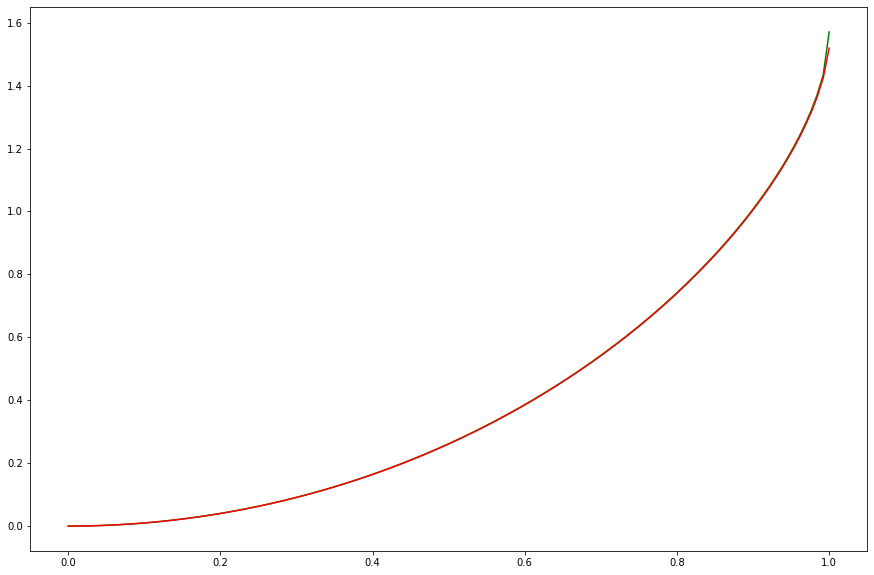

In [60]:
plt.figure(figsize=(15,10))
plt.plot(x, resy, color='green')
plt.plot(x, rky, color='red')
plt.show()

Jak widać wyniki są bardzo podobne, więc metoda Rungego-Kutty 4-tego rzędu bardzo dobrze przybliża prawidłowe rozwiązanie. Na wykresie praktycznie nie widać różnicy, największa różnica między 2 punktami wynosi mniej niż 0.052, a suma wszystkich różnic(dla $1+2^7$ punktów) jest mniejsza niż 0.21. Największą różnicę widać na prawym końcu przedziału dla 1, dla reszty jest praktycznie niewidoczna. Obrazuje to, że błąd się kumuluje, nawet przy dużej dokładności(przesuwamy się o $2^{-7}$). 

##### 3)  Używając tej samej metody rozwiąż zagadnienie początkowe dane równaniem x' = 100(sin(t) − x) z warunkiem początkowym x(0) = 0 na przedziale [0, 3] używając kroków o rozmiarach h = 0.015, 0.02, 0.025, 0.03. Opisz z czego wynikają różnice w rozwiązaniach.

In [62]:
def f2(t, x):
    return 100*(np.sin(t)-x)

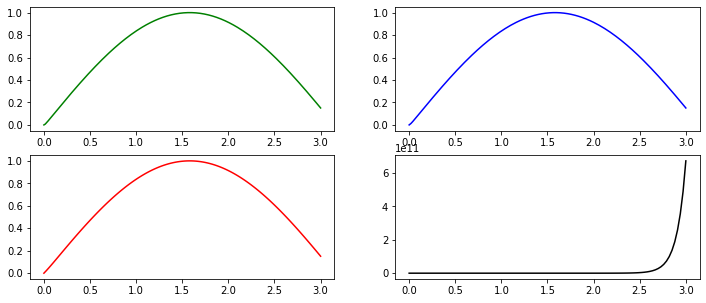

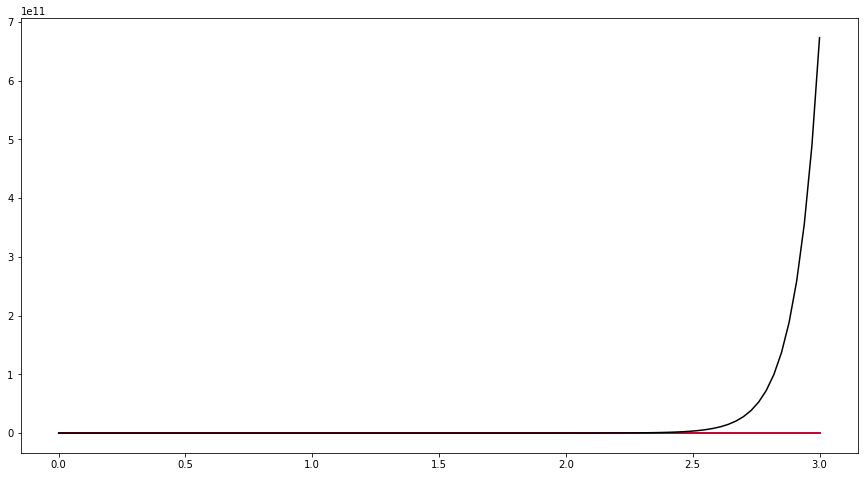

In [89]:
H = [0.015, 0.02, 0.025, 0.03]
colors = ['g', 'b', 'r', 'black']
# plt.figure(figsize=(15,10))
plt.figure(figsize=(12,5))
for ix, (h, col) in enumerate(zip(H, colors)):
    res = RK4th(f2, 0, 0, 3, h, True)
    plt.subplot(2,2,ix+1)
    plt.plot(np.linspace(0, 3, int(3/h)+1), res, color=col)
plt.show()

plt.figure(figsize=(15,8))
for h, col in zip(H, colors):
    res = RK4th(f2, 0, 0, 3, h, True)
    plt.plot(np.linspace(0, 3, int(3/h)+1), res, color=col)
plt.show()

Jak widąć dla h=0.03 wynik wychodzi zupełnie inny niż dla wszystkich poprzednich h(0.015, 0.02, 0.025).

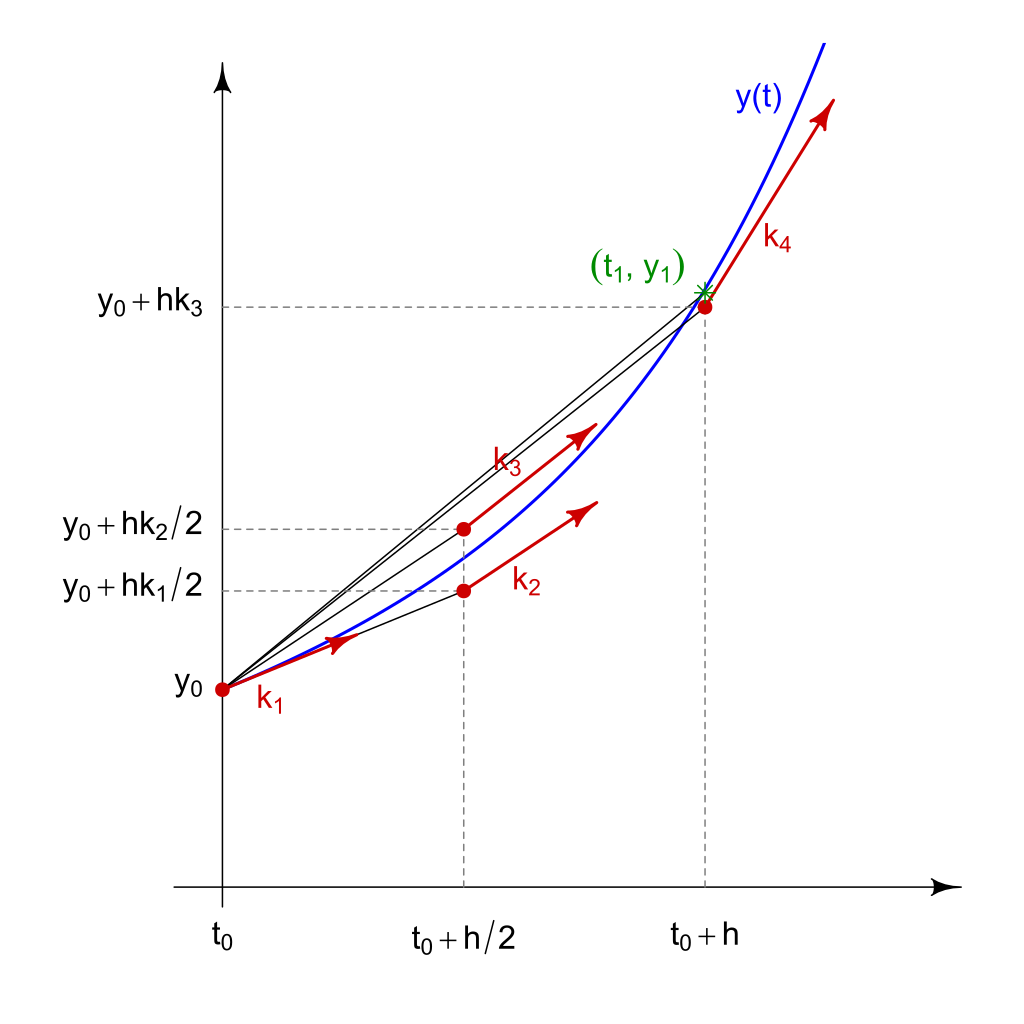

Obrazek dobrze pokazuje w jaki sposób metoda Rungego Kutty 4-tego rzędu przybliża następne punkty. Dla za dużego kroku, możemy pomijać bardzo istotne dla kształtu fragmentu.

### 2.  Adaptacyjna metoda Rungego-Kutty-Fehlberga

Zaimplementuj adaptacyjną metodę Rungego-Kutty-Fehlberga (rozdział 10.3, Kincaidi Cheney) i użyj jej do rozwiązania zagadnienia początkowego: $x' = 3x/t + 9/2t − 13$ z warunkiem brzegowym $x(3) = 6$ w punkcie x(1/2) z dokładnością do 9 miejsc po przecinku. Porównaj wynik z rozwiązaniem analitycznym $x = t^3−9/2t^2 + 13/2t$. W jaki sposób metoda adaptacyjna pozwala nam zwiększyć dokładność rozwiązania? Jakie są tego wady?

In [152]:
def RKF(f, a, b, x0, hmax, hmin, imax, epsmin, epsmax, tol=10**(-5)/2):
    
    a2 = 1/4
    a3 = 3/8
    a4 = 12/13
    a5 = 1
    a6 = 1/2

    b21 = 1/4
    b31 = 3/32
    b32 = 9/32
    b41 = 1932/2197
    b42 = -7200/2197
    b43 = 7296/2197
    b51 = 439/216
    b52 = -8
    b53 = 3680/513
    b54 = -845/4104
    b61 = -8/27
    b62 = 2
    b63 = -3544/2565
    b64 = 1859/4104
    b65 = -11/40

    r1 = 16/135
    r3 = 6656/12825
    r4 = 28561/56430
    r5 = -9/50
    r6 = 2/55

    c1 = 25/216
    c3 = 1408/2565
    c4 = 2197/4104
    c5 = -1/5

    t = a
    x = x0
    h = hmax*np.sign((b-a))
    
    flag = False
    
    k=0
    while k<=imax:
        if abs(h) < hmin:
            h = np.sign(h)*hmin
        if abs(h) > hmax:
            h = np.sign(h)*hmax
        
        d = np.abs(b-t)
        if d<=np.abs(h):
            flag=True
            if d<=tol*max(np.abs(b), np.abs(t)):
                break
            h = np.sign(h)*d
        
        xpre = x
        tpre = t
        
        k1 = h*f(t, x)
        k2 = h*f(t+a2*h, x+b21*k1)
        k3 = h*f(t+a3*h, x+b31*k1+b32*k2)
        k4 = h*f(t+a4*h, x+b41*k1+b42*k2+b43*k3)
        k5 = h*f(t+a5*h, x+b51*k1+b52*k2+b53*k3+b54*k4)
        k6 = h*f(t+a6*h, x+b61*k1+b62*k2+b63*k3+b64*k4+b65*k5)
        
        x4 = x+c1*k1+c3*k3+c4*k4+c5*k5
        x += r1*k1+r3*k3+r4*k4+r5*k5+r6*k6
        t += h
        eps = np.abs(x-x4)
        if flag:
            break
        if eps<epsmin:
            h = 2*h
        if eps>epsmax:
            h = h/2
            x = xpre
            t = tpre
            k -= 1
    return x, t

In [153]:
def xf3(t):
    return t**3-9*t**2/2+13*t/2

def f3(t, x):
    return 3*x/t+9*t/2-13

In [159]:
ex=xf3(1/2)
go=RKF(f3, 3, 1/2, 6, 1, 10**(-9), 10**6, 10**(-12), 10**(-9))[0]
print("Expected: ", ex)
print("Got: ", go)
print("Difference: ", abs(go-ex))

Expected:  2.25
Got:  2.250000000298037
Difference:  2.98037150514574e-10


Jak widać otrzymujemy wynik bardzo dokładnie (<$10^{-9}$). Otrzymujemy taką dokładność, dzięki adapcyjnemu podejściu, wyliczamy kilka wartości więcej, dzięki czemu otrzymujemy dokładniejsze wyniki, ale przede wszystkim w zależności od różnicy między dwoma otrzymanymi wynikami (tutaj kontrolujemy naszą dokładność rozwiązania) zwiększamy lub zmniejszamy dwukrotnie nasz krok (h). Oba wyniki przybliżają nam wartość w t+h, ale różnią się nieco sposobem wyliczenia i liczbą wymaganych wyliczeń funkcji(5 do 6 i inne stałe), ale wyliczają ją w tych samych miejscach, dzięki czemu wyliczamy ją tylko 6 razy (dla każdego miejsca raz).

\+ Największą zaletą adaptacyjnej metody Rungego-Kutty-Fehlberga, jest niewątpliwie możliwość wyboru dokładności rozwiązania.\
\- Jednymi z wad, na pewno są wymóg dodatkowych wyliczeń funkcji, które mogą być wymagające i czasochłonne, oraz dużej liczby obliczeń zmiennoprzecinkowych.\
\+ Jednak dzięki adapcyjności tego podejścia, możemy również pominąć bardzo duże fragmenty, które podstawowym algorytmem musielibyśmy przechodzić po malutkich odcinkach i dla każdego z nich wszystko wyliczać.\
\- Czasami zdarza się, że wykonujemy wszystkie obliczenia, a następnie wykorzystujemy je tylko i wyłącznie do stwierdzenia, że dokładność jest za mała i zmniejszenia h (co się wiążę z kilkoma kolejnymi wyliczeniami na tym samym przedziale).